In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

2023-05-26 16:34:16.273829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Note: Some metrics need to be defined manually

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [3]:
#load data(sometimes need to use "/")
df = pd.read_csv('/home/team_1/ann_demo/ANN_Timeseries_Forecast_python_demo/Data/Rainfall_Forecast.csv')
# Colab
#df = pd.read_csv('')
df

,Year,Month,Day,Y
0,2000,1,1,48.25
1,2000,2,1,50.81
2,2000,3,1,42.88
3,2000,4,1,55.69
4,2000,5,1,70.88
...,...,...,...,...
247,2020,8,1,92.31
248,2020,9,1,90.12
249,2020,10,1,82.69
250,2020,11,1,76.06


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [4]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df.iloc[:,[0,1,2]])
df

,Year,Month,Day,Y,Date
0,2000,1,1,48.25,2000-01-01
1,2000,2,1,50.81,2000-02-01
2,2000,3,1,42.88,2000-03-01
3,2000,4,1,55.69,2000-04-01
4,2000,5,1,70.88,2000-05-01
...,...,...,...,...,...
247,2020,8,1,92.31,2020-08-01
248,2020,9,1,90.12,2020-09-01
249,2020,10,1,82.69,2020-10-01
250,2020,11,1,76.06,2020-11-01


In [5]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    252 non-null    int64         
 1   Month   252 non-null    int64         
 2   Day     252 non-null    int64         
 3   Y       252 non-null    float64       
 4   Date    252 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 10.0 KB


In [6]:
new_df=df.iloc[:,[4,3]].copy()
new_df.head()

,Date,Y
0,2000-01-01,48.25
1,2000-02-01,50.81
2,2000-03-01,42.88
3,2000-04-01,55.69
4,2000-05-01,70.88


In [7]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Y
count,252.000000
mean,67.259524
std,17.307101
min,34.690000
25%,51.845000
50%,66.655000
75%,84.610000
max,92.310000


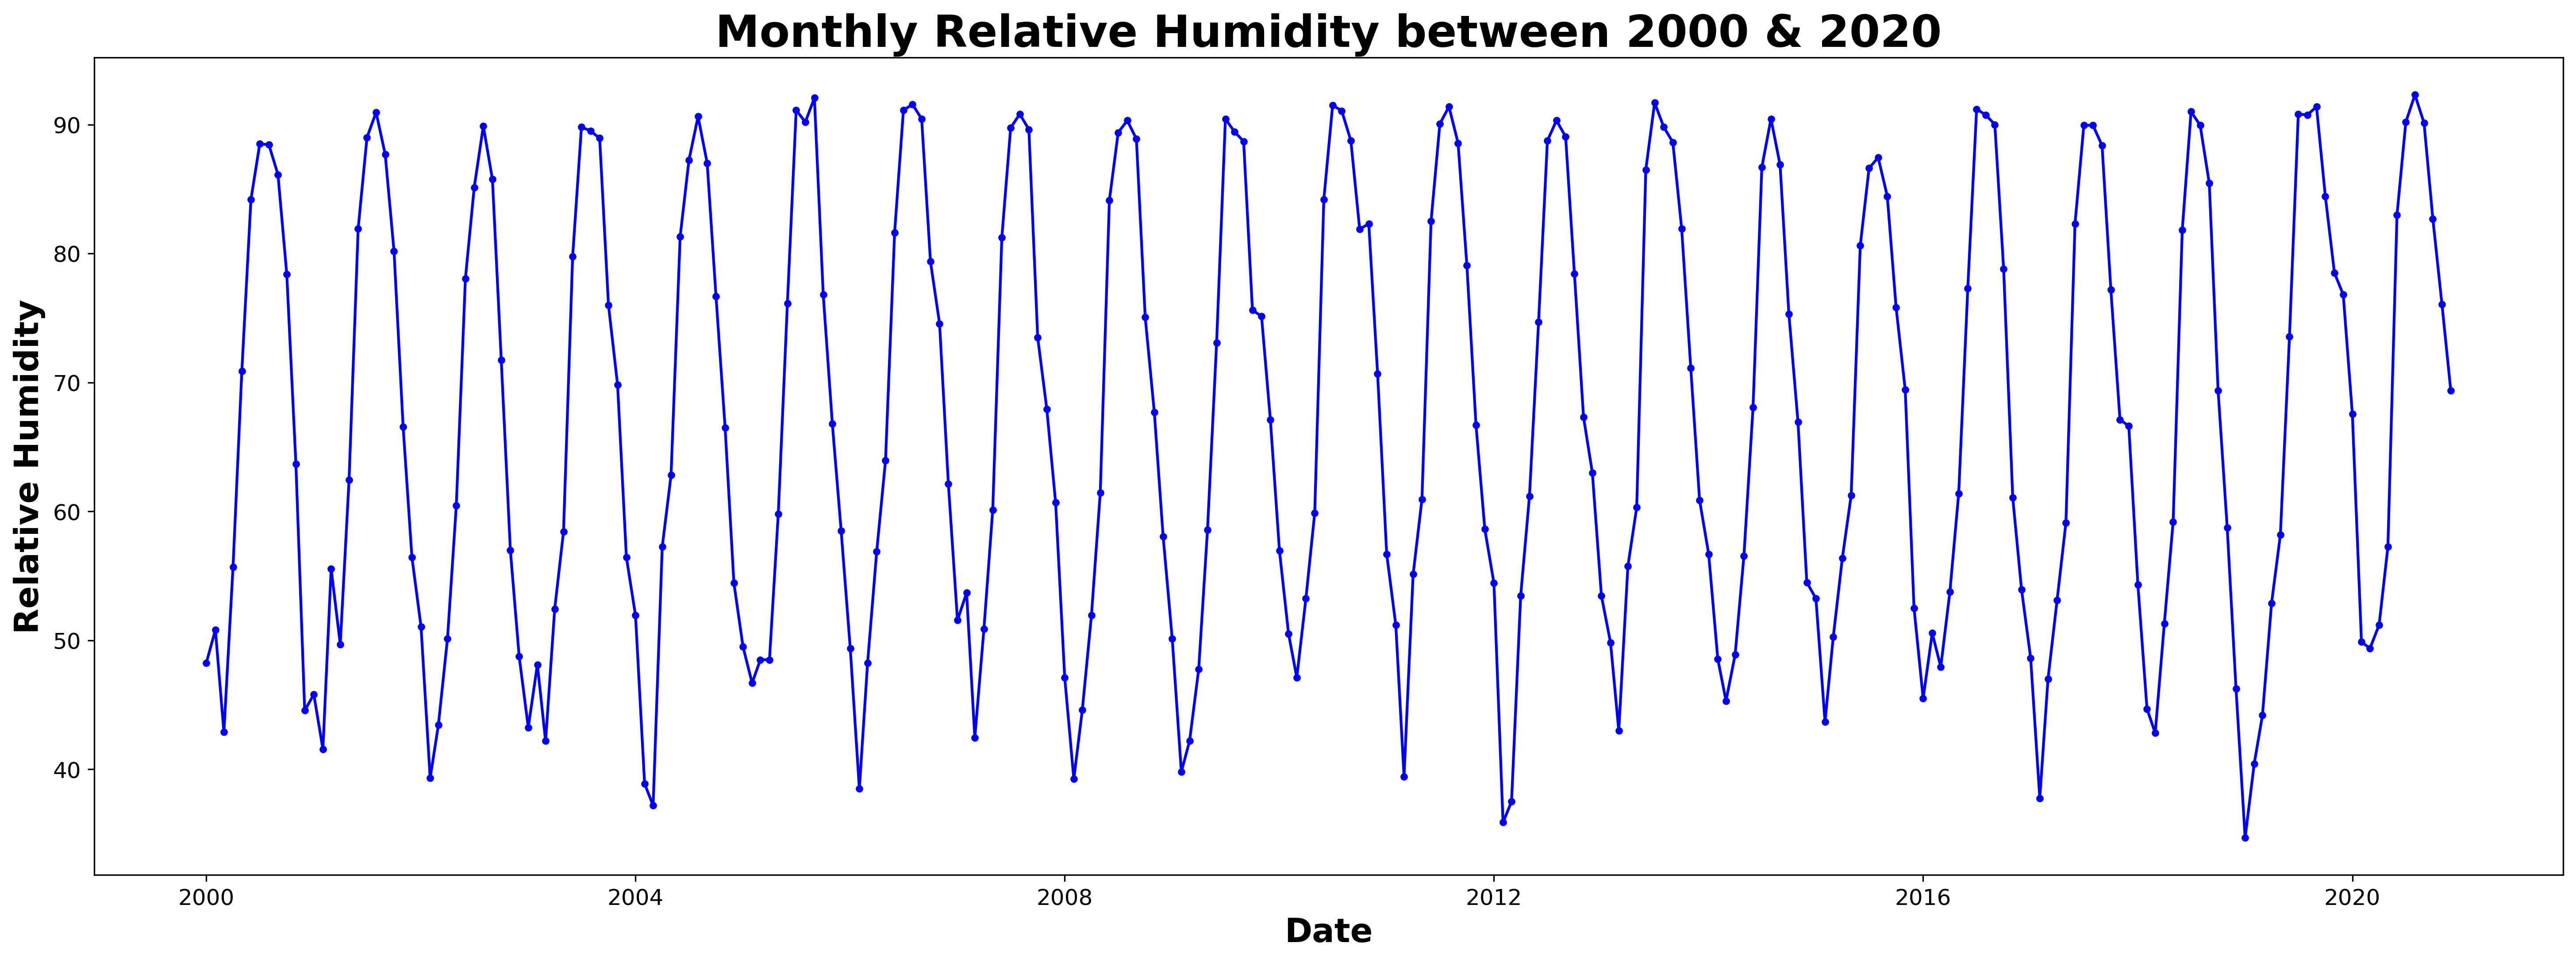

In [8]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity between 2000 & 2020',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [9]:
# Create 3 lags
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

,Date,Y,Lag_1,Lag_2,Lag_3
0,2000-01-01,48.25,NaN,NaN,NaN
1,2000-02-01,50.81,48.25,NaN,NaN
2,2000-03-01,42.88,50.81,48.25,NaN
3,2000-04-01,55.69,42.88,50.81,48.25
4,2000-05-01,70.88,55.69,42.88,50.81


In [10]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2000-04-01,55.69,42.88,50.81,48.25
1,2000-05-01,70.88,55.69,42.88,50.81
2,2000-06-01,84.19,70.88,55.69,42.88
3,2000-07-01,88.50,84.19,70.88,55.69
4,2000-08-01,88.44,88.50,84.19,70.88
...,...,...,...,...,...
244,2020-08-01,92.31,90.19,83.00,57.25
245,2020-09-01,90.12,92.31,90.19,83.00
246,2020-10-01,82.69,90.12,92.31,90.19
247,2020-11-01,76.06,82.69,90.12,92.31


In [11]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [12]:
# Train data
Forecast_train_data=clean_df.iloc[0:213,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2000-04-01,55.69,42.88,50.81,48.25
1,2000-05-01,70.88,55.69,42.88,50.81
2,2000-06-01,84.19,70.88,55.69,42.88
3,2000-07-01,88.50,84.19,70.88,55.69
4,2000-08-01,88.44,88.50,84.19,70.88
...,...,...,...,...,...
208,2017-08-01,89.94,89.94,82.31,59.12
209,2017-09-01,88.38,89.94,89.94,82.31
210,2017-10-01,77.19,88.38,89.94,89.94
211,2017-11-01,67.12,77.19,88.38,89.94


In [13]:
# Test data
Forecast_test_data=clean_df.iloc[213:213+36,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
213,2018-01-01,54.31,66.62,67.12,77.19
214,2018-02-01,44.69,54.31,66.62,67.12
215,2018-03-01,42.81,44.69,54.31,66.62
216,2018-04-01,51.31,42.81,44.69,54.31
217,2018-05-01,59.19,51.31,42.81,44.69
218,2018-06-01,81.81,59.19,51.31,42.81
219,2018-07-01,91.00,81.81,59.19,51.31
220,2018-08-01,89.94,91.00,81.81,59.19
221,2018-09-01,85.44,89.94,91.00,81.81
222,2018-10-01,69.38,85.44,89.94,91.00


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [14]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:105,:].copy()
Exp_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:141,:].copy()
Exp_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:177,:].copy()
Exp_val_3=Forecast_train_data.iloc[177:177+36,:].copy()

# Rolling window

In [15]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:105,:].copy()
Rol_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[33:141,:].copy()
Rol_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[69:177,:].copy()
Rol_val_3=Forecast_train_data.iloc[177:177+36,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [16]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Y'].copy()
y_val=Exp_val_3['Y'].copy()

In [17]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

# 6. Creating Net 

In [18]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.103700,0.248223,0.201567
1,0.337161,0.103700,0.248223
2,0.613997,0.337161,0.103700
3,0.856570,0.613997,0.337161
4,0.935119,0.856570,0.613997


In [19]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [20]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from tensorflow.keras.saving import get_custom_objects #for colab version problem
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [21]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

2023-05-26 16:34:28.569850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 16:34:28.577210: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [22]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
2/2 [==============================] - 3s 824ms/step - loss: 67.2454 - mean_absolute_percentage_error: 100.0383 - val_loss: 68.7513 - val_mean_absolute_percentage_error: 99.9483
Epoch 2/300
2/2 [==============================] - 0s 283ms/step - loss: 67.1706 - mean_absolute_percentage_error: 99.9234 - val_loss: 68.6775 - val_mean_absolute_percentage_error: 99.8394
Epoch 3/300
2/2 [==============================] - 0s 242ms/step - loss: 67.0985 - mean_absolute_percentage_error: 99.8145 - val_loss: 68.6052 - val_mean_absolute_percentage_error: 99.7332
Epoch 4/300
2/2 [==============================] - 0s 260ms/step - loss: 67.0281 - mean_absolute_percentage_error: 99.7092 - val_loss: 68.5336 - val_mean_absolute_percentage_error: 99.6283
Epoch 5/300
2/2 [==============================] - 0s 285ms/step - loss: 66.9589 - mean_absolute_percentage_error: 99.6032 - val_loss: 68.4630 - val_mean_absolute_percentage_error: 99.5249
Epoch 6/300
2/2 [==============================] - 0s 

In [23]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

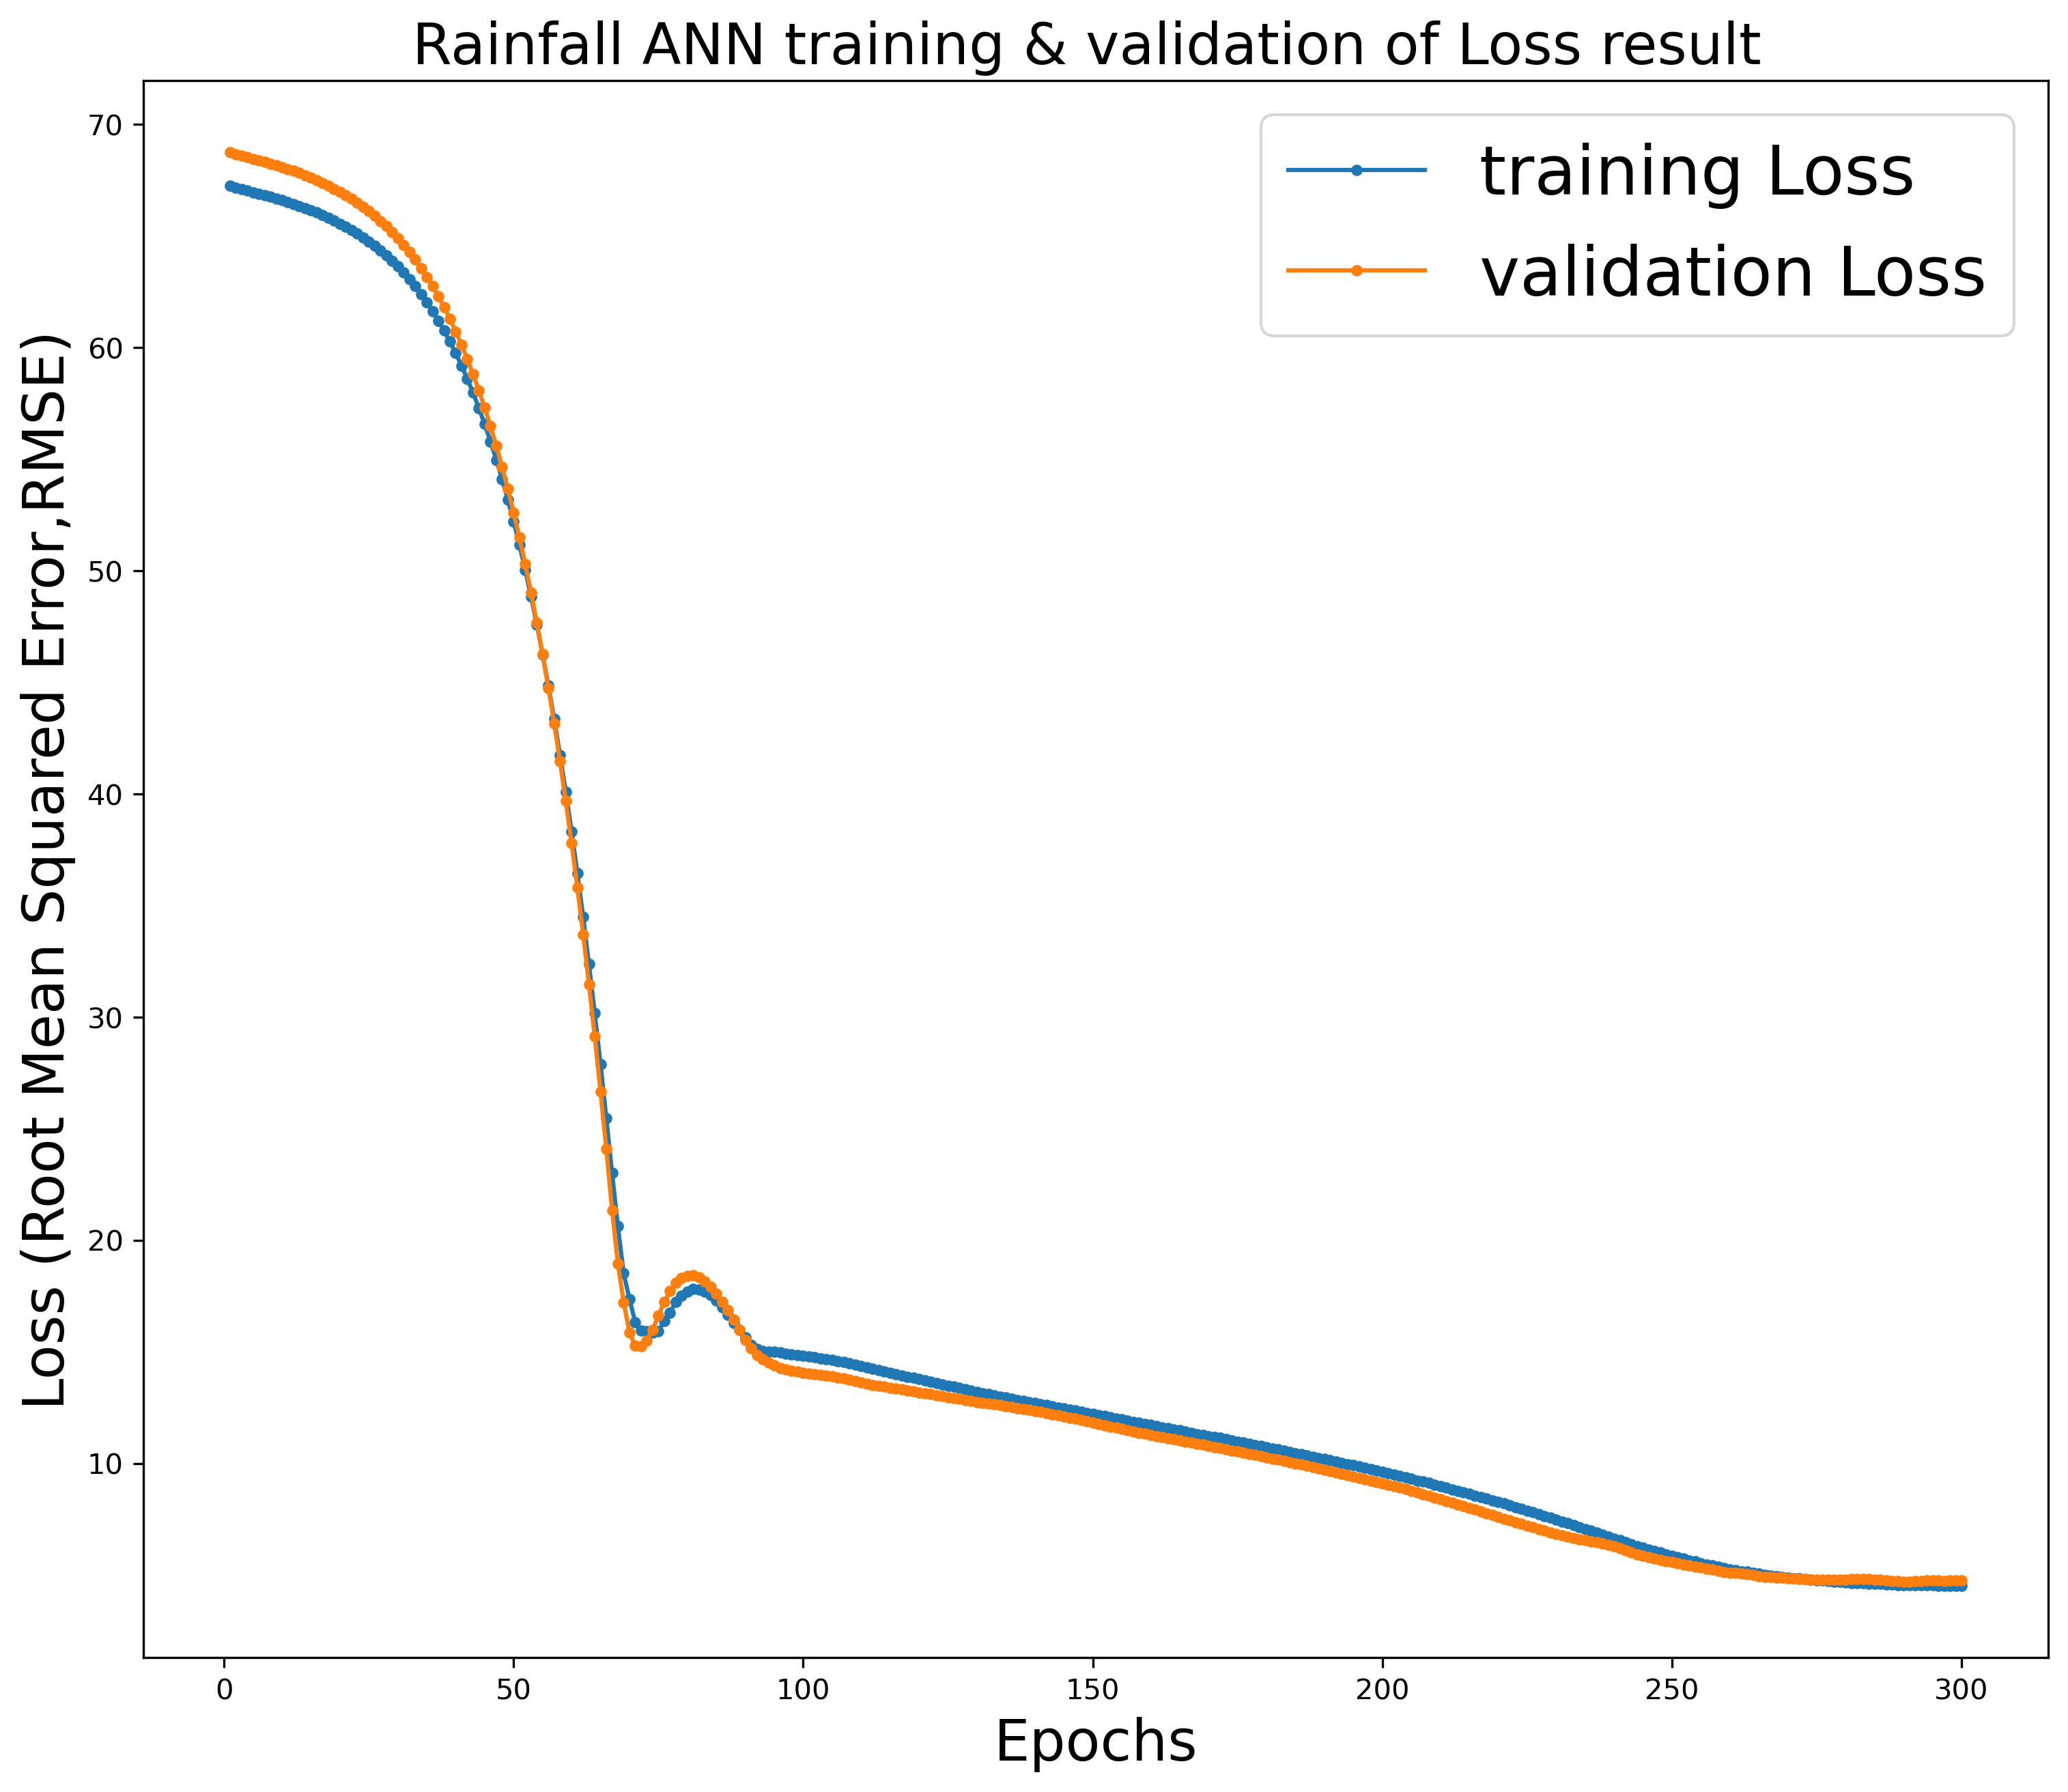

In [24]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

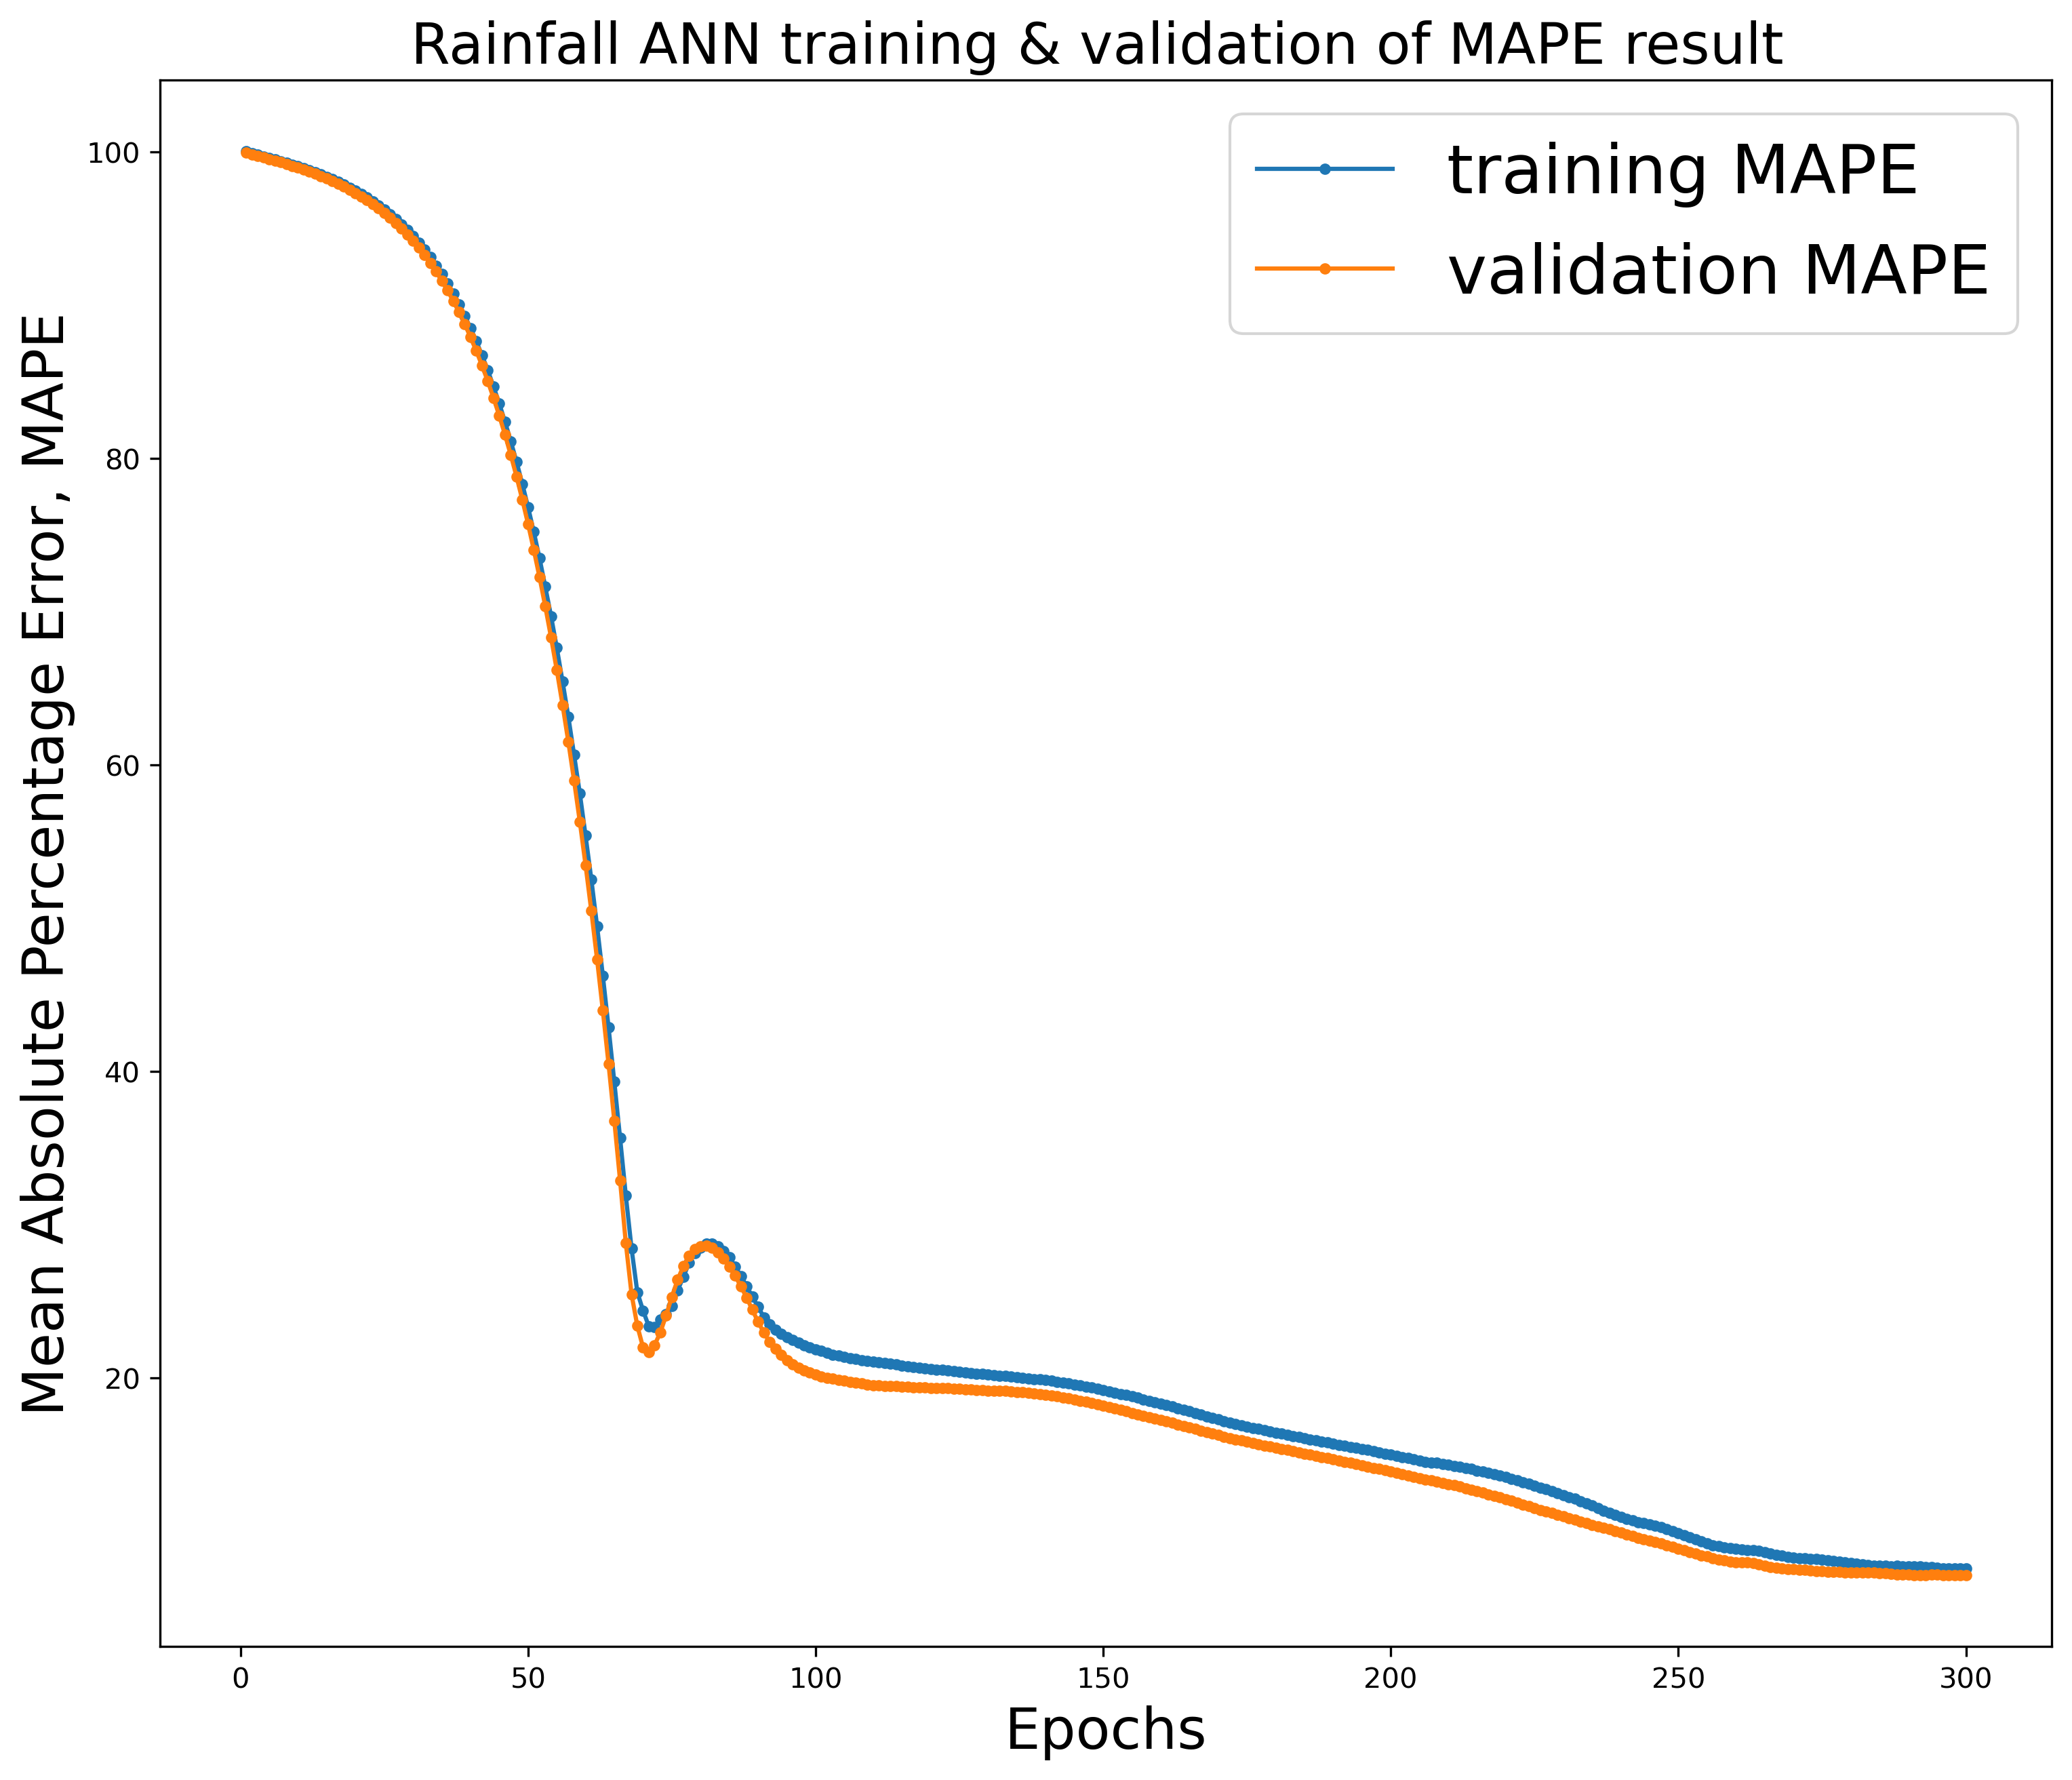

In [25]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [26]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [27]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
4/4 [==============================] - 1s 12ms/step - loss: 49.9660 - mean_absolute_percentage_error: 73.2957
Epoch 2/300
4/4 [==============================] - 0s 3ms/step - loss: 42.5518 - mean_absolute_percentage_error: 62.1486
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 34.5748 - mean_absolute_percentage_error: 50.0724
Epoch 4/300
4/4 [==============================] - 0s 4ms/step - loss: 26.0068 - mean_absolute_percentage_error: 36.8504
Epoch 5/300
4/4 [==============================] - 0s 5ms/step - loss: 17.5200 - mean_absolute_percentage_error: 24.2106
Epoch 6/300
4/4 [==============================] - 0s 6ms/step - loss: 12.6728 - mean_absolute_percentage_error: 18.5093
Epoch 7/300
4/4 [==============================] - 0s 5ms/step - loss: 11.9219 - mean_absolute_percentage_error: 19.1338
Epoch 8/300
4/4 [==============================] - 0s 6ms/step - loss: 13.6252 - mean_absolute_percentage_error: 22.4271
Epoch 9/300
4/4 [==============

In [29]:
# 7.3 Save the trained model
Fmodel.save('./Rainfall_forecast_ANN_trained_model.h5')
# Colab
#model.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [30]:
# 7.4 Restore the saved model for testing
ANN_model=keras.models.load_model('./Rainfall_forecast_ANN_trained_model.h5')
# Colab
#ANN_model=keras.models.load_model('')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [31]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [32]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [33]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
213,2018-01-01,54.31,59.619999,5.309999
214,2018-02-01,44.69,50.889999,6.199999
215,2018-03-01,42.81,44.020000,1.210000
216,2018-04-01,51.31,43.320000,7.990000
217,2018-05-01,59.19,57.139999,2.050001
218,2018-06-01,81.81,64.629997,17.180003
219,2018-07-01,91.00,90.620003,0.379997
220,2018-08-01,89.94,94.019997,4.079997
221,2018-09-01,85.44,86.019997,0.579997
222,2018-10-01,69.38,75.309998,5.929998


In [34]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 5.124
MSE: 49.126
RMSE: 7.009
MAPE: 8.177 %
SMAPE: 8.23 %
RAE: 0.313
MRAE: 0.008706672717111083
MdRAE: 0.249 bench: 68.07
RSE: 0.15
RRSE: 0.388


#  Plot for comparing true value & predicted value 

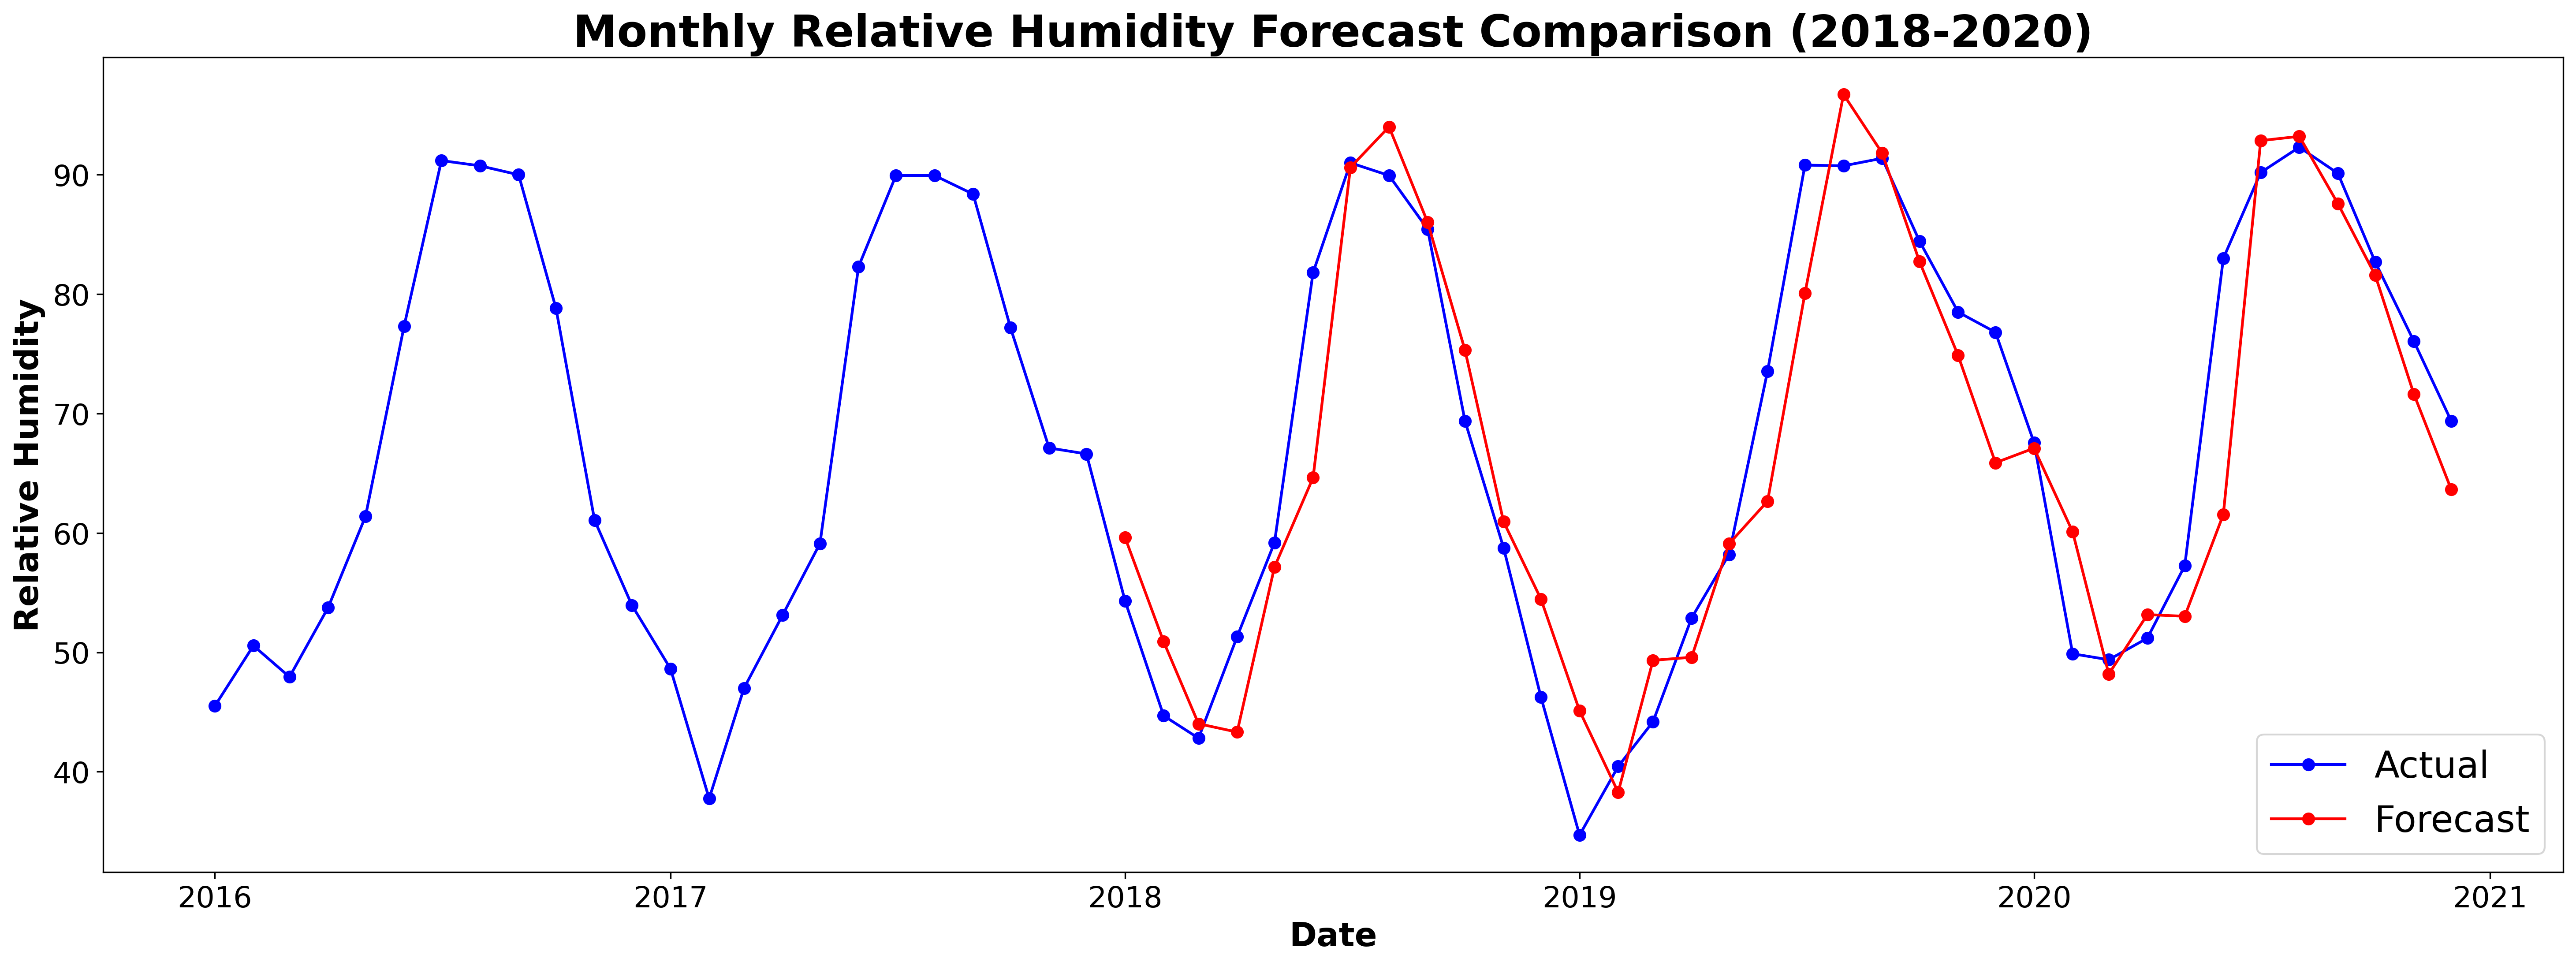

In [35]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

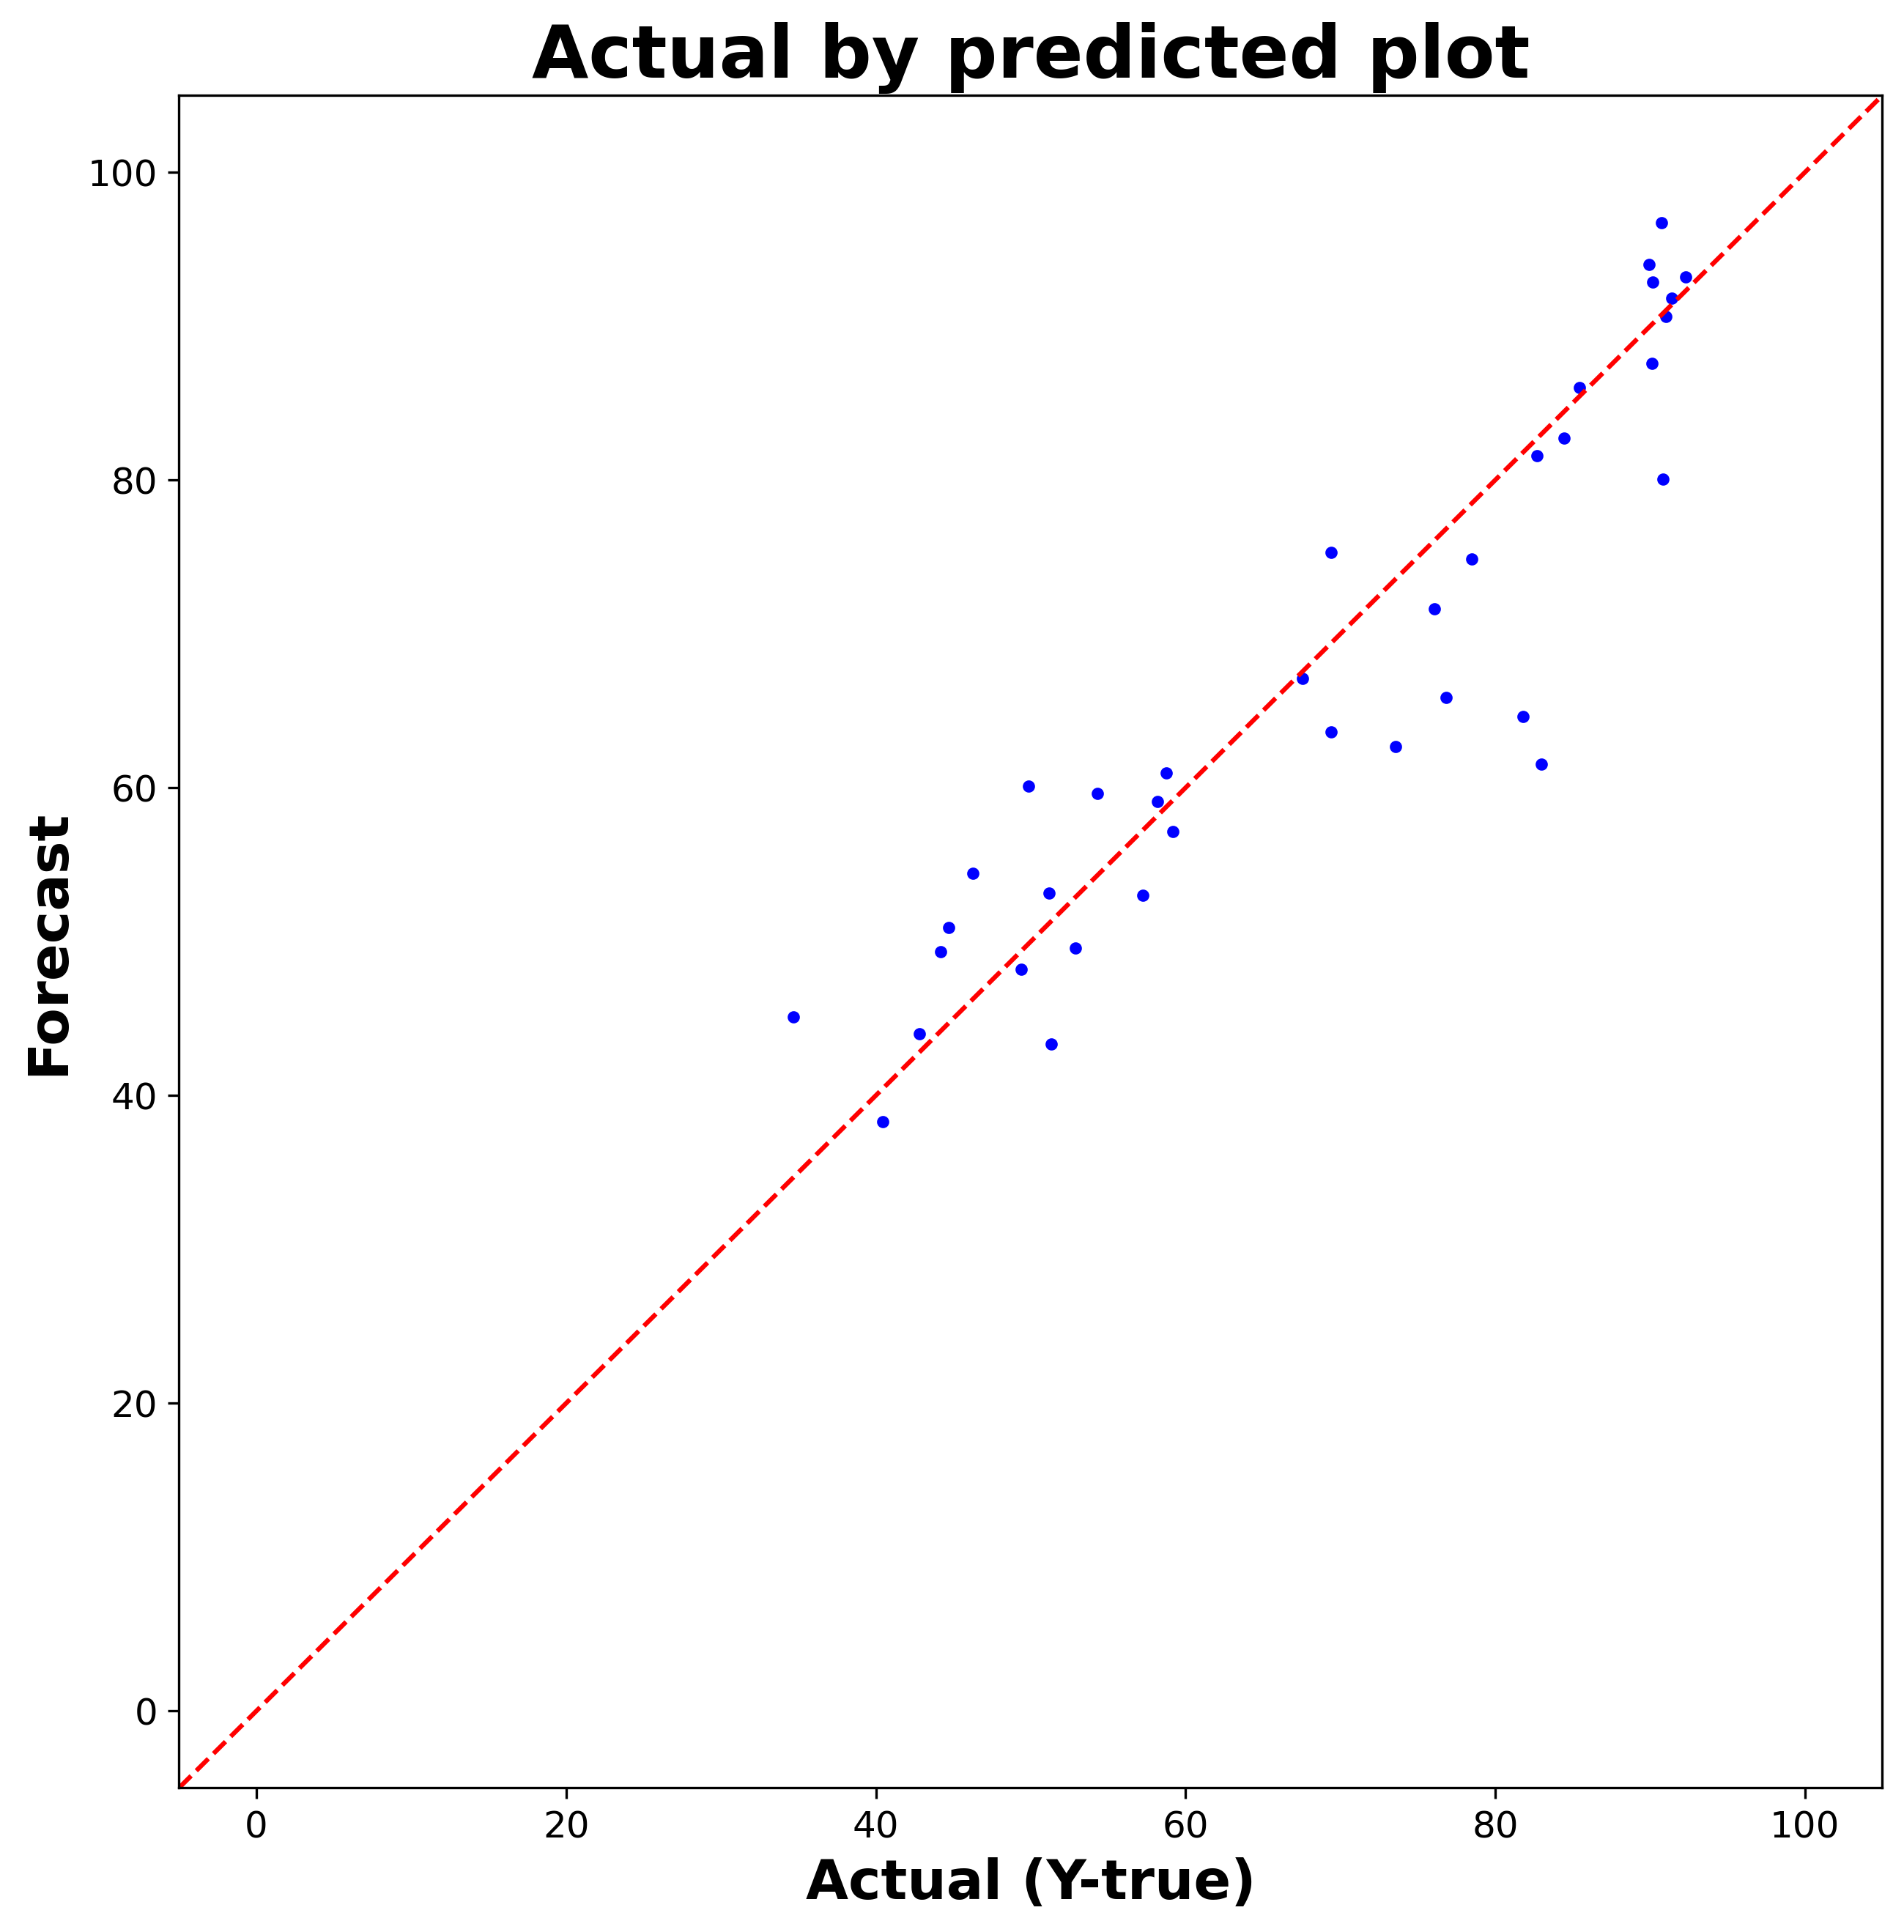

In [36]:
# Lock the scale of axis by Y_true
max_value=100+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()